<a href="https://colab.research.google.com/github/sergetyum/Final_Check_Work/blob/main/%D0%90_%D0%92_%D1%82%D0%B5%D1%81%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%9F%D1%80%D0%BE%D0%BC%D0%B5%D0%B6%D1%83%D1%82%D0%BE%D1%87%D0%BD%D0%B0%D1%8F_%D0%B0%D1%82%D1%82%D0%B5%D1%81%D1%82%D0%B0%D1%86%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **A/B-тестирование (семинары)**

### **Урок 9. Python применение продвинутых методов**

Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

Mobile Games AB Testing with Cookie Cats

Дано:

userid - уникальный номер игрока

version - версия контрольной группы: gate30 (с уровнем 30) или gate40 (с уровнем 40)

sum_gamerounds - количество игровых раундов, проведенных игроком в течение первых 14 дней после установки

retention_1 - вернулся ли игрок через 1 день после установки

retention_7 - вернулся ли игрок через 7 дней после установки


## Решение

Загрузка библиотек

In [3]:
from scipy.stats import ttest_1samp
import numpy as np
import pandas as pd


from scipy.stats import norm, t, kstest, shapiro
import statsmodels.api as sm
from matplotlib import pyplot as plt


import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

Загружаем файл "Промежуточная аттестация" с google диска и выведем первые 5 строк

In [4]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_excel('/content/drive/MyDrive/Промежуточная аттестация.xlsx')

data.head(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [5]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


В файле 90189 строк, нулевых строк нет.

In [6]:
data.shape

(90189, 5)

Количество уникальных игроков:

In [7]:
data['userid'].nunique()

90189

Оценим количество игроков в каждой тестовой группе (gate30 и gate40).

In [8]:
data.groupby('version')['version'].count()

version
gate_30    44700
gate_40    45489
Name: version, dtype: int64

Количество игроков в тестовых группах примерно одинаково.

Построим график распределения количества игровых раундов, сыгранных в течение 1 недели

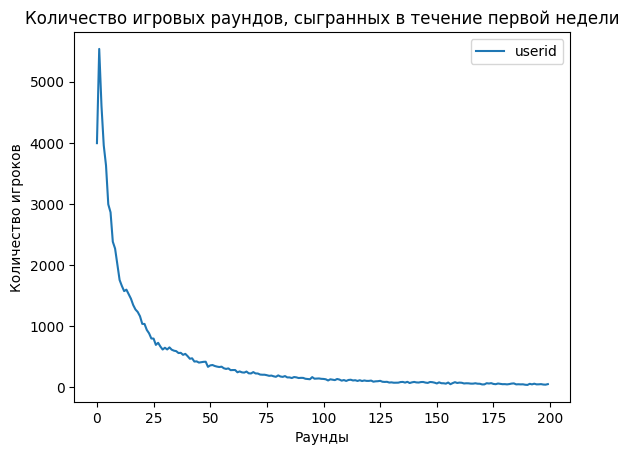

In [9]:
plot_df = data.groupby('sum_gamerounds').count().reset_index()

ax = plot_df.head(n=200).plot('sum_gamerounds', 'userid')
ax.set_xlabel("Раунды")
ax.set_ylabel("Количество игроков")
ax.set_title("Количество игровых раундов, сыгранных в течение первой недели");

Видим, что некоторое количество пользователей устанавливают игру, но не играют в нее.

Таких пользователей:

In [10]:
data[data["sum_gamerounds"]== 0]["userid"].count()

3994

Посчитаем однодневные и семидневные удержания.

In [11]:
df_retention = data[["retention_1","retention_7"]].mean()*100
print(f"1-day retention ratio: {round(df_retention[0],2)}% \
      \n7-days retention ratio: {round(df_retention[1],2)}%")

1-day retention ratio: 44.52%       
7-days retention ratio: 18.61%


Мы видим, что 44,52% игроков возвращаются через день после установки игры и лишь 18,61% игроков возвращаются через 7 дней после установки игры.

Прроверим, как показатели удержания отличаются между двумя группами gate30 и gate40.

In [14]:
df_retention_ab = data.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


В группе gate40, по сравнению с контрольной группой, видим небольшое снижение однодневного удержания до 44,2%, в то же время в группе  gate30, наоборот, видим небольшое увеличение до 44,8%.

Также ведет себя и  семидневное удержание: в gate40  видим небольшое снижение
 до 18,2% по сравнению с контрольной группой, в группе gate30 небольшое увеличение до 19%.

С помощью метода Bootstrapp создадим образцы начальной загрузки для групп gate30 и gate40.

In [21]:
boot_1d = []
boot_7d = []
for i in range(1000):
    boot_mean_1 = data.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = data.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)

Преобразуем образцы в DataFrame

In [22]:
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

Выведем графики распределения однодневного и семидневного удержания в группах:

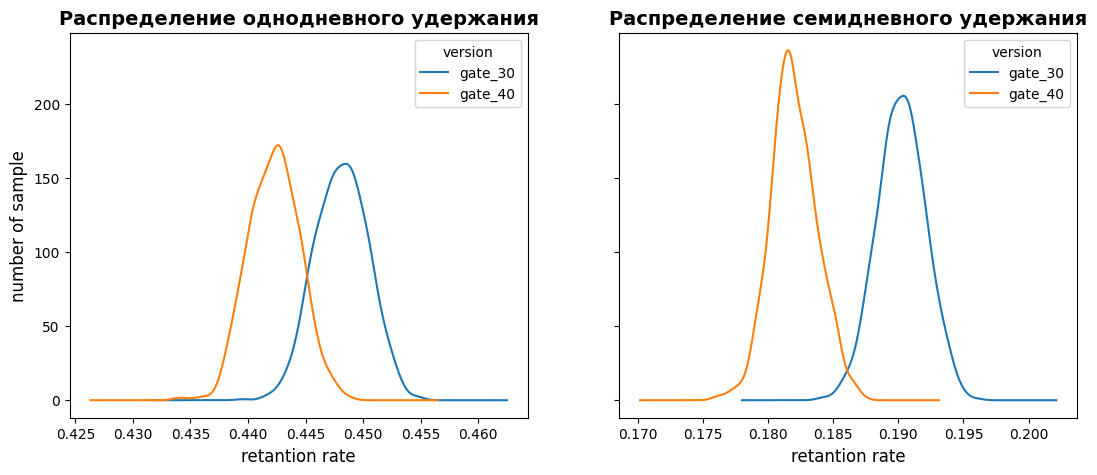

In [26]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("retantion rate",size=12)
ax1.set_ylabel("number of sample",size=12)
ax1.set_title("Распределение однодневного удержания", fontweight="bold",size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("retantion rate",size=12)
ax2.set_title("Распределение семидневного удержания", fontweight="bold",size=14)
plt.show()

Видим небольшую разницу как в однодневных т. и в семидневных удержанииях в обеих группах.

Вычислим процентную разницу:

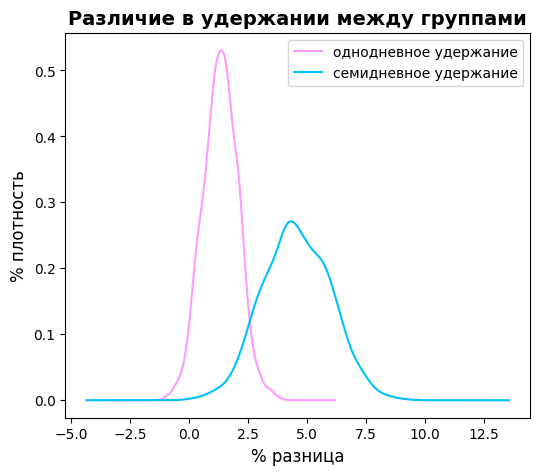

In [40]:
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)
fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "однодневное удержание")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "семидневное удержание")
ax1.set_xlabel("% разница",size=12)
ax1.set_ylabel("% плотность",size=12)
ax1.set_title("Различие в удержании между группами", fontweight="bold", size=14)
plt.legend()
plt.show()


Из этого графика видно, что разница в однодневных удержаниях составляет 1 - 2%, а для семидневного удержания 2 - 5%.

Посчитаем одно и семидневные удержания (в %), когда игрок  находится на уровне выше 30.

In [38]:
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])
print(f"Вероятность однодневного удержания выше, когда игрок достигает уровня 30: {round(prob_1,2)*100}% \
      \nВероятность семидневного удержания выше, когда игрок достигает уровня 30: {(prob_7)*100}% ")

Вероятность однодневного удержания выше, когда игрок достигает уровня 30: 97.0%       
Вероятность семидневного удержания выше, когда игрок достигает уровня 30: 100.0% 


Результат bootstrap показывает, что семидневные удержания выше, когда игроки проходит уровень 30.

**Если мы хотим сохранить как однодневные, т. и семидневные удержания на высоком уровне, мы не должны позволять игрокам подниматься выше уровня 30.**